# Step 1: PDF to Image Conversion Pipeline

This notebook converts all PDFs in the data directory to high-quality images for processing through the NeMo Retriever Parse pipeline.

## Overview

- **Input**: PDF files in the data directory structure
- **Output**: 300 DPI PNG images in organized folder structure
- **Methods**: Both pdf2image and PyMuPDF (fitz) for maximum compatibility
- **Storage**: Dual storage (local + central) for organization and pipeline processing

## Pipeline Steps

1. **PDF Discovery**: Find all PDF files recursively
2. **Conversion**: Convert using both pdf2image and PyMuPDF methods
3. **Organization**: Save in local and central locations
4. **Validation**: Verify conversion quality and completeness
5. **Reporting**: Generate comprehensive processing report


In [2]:
# Install required packages
# %pip install PyMuPDF pdf2image pillow tqdm ipywidgets seaborn

In [2]:
import os
import json
import time
import warnings
from pathlib import Path
from typing import Dict, List, Any, Tuple, Optional
import pymupdf  # pymupdf is the same as fitz, different names
from PIL import Image
from pdf2image import convert_from_path
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timezone
import multiprocessing
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

# Configuration
CONFIG = {
    'DPI': 300,
    'OUTPUT_FORMAT': 'PNG',
    'MAX_WORKERS': min(8, multiprocessing.cpu_count()),
    'BATCH_SIZE': 50,
    'QUALITY_THRESHOLD': 0.95,  # Minimum quality score for converted images
}

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up paths (project-local)
WORKSPACE_ROOT = Path.cwd()
# input data directory. Change this to the path of your data directory
DATA_DIR = WORKSPACE_ROOT / "data" / "test"
# output data directory
OUTPUT_DIR = WORKSPACE_ROOT / "output_results" / "converted_images"

print("✅ Dependencies installed successfully!")
print(f"📁 Primary data root: {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"⚙️  Configuration: {CONFIG}")


✅ Dependencies installed successfully!
📁 Primary data root: /home/ubuntu/nim-dev/models/nemotron-parse-prod-hf/data/test
📁 Output directory: /home/ubuntu/nim-dev/models/nemotron-parse-prod-hf/output_results/converted_images
⚙️  Configuration: {'DPI': 300, 'OUTPUT_FORMAT': 'PNG', 'MAX_WORKERS': 8, 'BATCH_SIZE': 50, 'QUALITY_THRESHOLD': 0.95}


## 📁 PDF Discovery and Inventory

First, let's discover all PDF files in the data directory and create a comprehensive inventory.


In [3]:
# PDF discovery scoped to workspace data directory
from pathlib import Path

def discover_all_pdfs(search_dir: Path) -> List[Path]:
    return sorted(search_dir.rglob("*.pdf"))

print("🔍 Discovering PDF files...")
SEARCH_DIR = DATA_DIR
print("🔎", SEARCH_DIR)

pdf_paths = discover_all_pdfs(SEARCH_DIR)

# Build inventory table
records = []
for p in pdf_paths:
    try:
        stat = p.stat()
        try:
            doc = pymupdf.open(str(p))
            page_count = len(doc)
            doc.close()
        except Exception:
            page_count = None
        records.append({
            'filename': p.name,
            'path': str(p),
            'size_mb': round(stat.st_size / 1e6, 2),
            'modified': datetime.fromtimestamp(stat.st_mtime).strftime('%Y-%m-%d %H:%M:%S'),
            'page_count': page_count,
        })
    except Exception as e:
        print(f"⚠️  Could not stat {p}: {e}")

print("\n📊 PDF Inventory Summary:")
print(f"   📄 Total PDFs: {len(records)}")
print(f"   📑 Total Pages: {sum(r['page_count'] or 0 for r in records)}")
print(f"   💾 Total Size: {sum(r['size_mb'] for r in records):.2f} MB")

if records:
    pdf_df = pd.DataFrame(records)
    display(pdf_df.head(20))



🔍 Discovering PDF files...
🔎 /home/ubuntu/nim-dev/models/nemotron-parse-prod-hf/data/test

📊 PDF Inventory Summary:
   📄 Total PDFs: 1
   📑 Total Pages: 43
   💾 Total Size: 2.67 MB


,filename,path,size_mb,modified,page_count
0,a_map.pdf,/home/ubuntu/nim-dev/models/nemotron-parse-pro...,2.67,2025-11-25 00:15:56,43


## 🔄 PDF to Image Conversion Functions

Implementation of robust PDF to image conversion using both pdf2image and PyMuPDF (fitz) methods for maximum compatibility.


In [4]:
class PDFConverter:
    """Enhanced PDF to Image converter with multiple methods and quality validation."""
    
    def __init__(self, dpi: int = 300, output_format: str = "PNG"):
        self.dpi = dpi
        self.output_format = output_format
        self.conversion_stats = {
            'successful': 0,
            'failed': 0,
            'total_pages': 0,
            'total_time': 0,
            'errors': []
        }
    
    def validate_image_quality(self, image: Image.Image, min_width: int = 100, min_height: int = 100) -> Tuple[bool, float]:
        """
        Validate the quality of a converted image.
        
        Returns:
            Tuple[bool, float]: (is_valid, quality_score)
        """
        try:
            width, height = image.size
            
            # Basic size validation
            if width < min_width or height < min_height:
                return False, 0.0
            
            # Calculate quality score based on various factors
            quality_score = 1.0
            
            # Size factor (larger images generally better)
            size_factor = min(1.0, (width * height) / (1000 * 1000))  # Normalize to 1MP
            quality_score *= (0.7 + 0.3 * size_factor)
            
            # Check if image is not completely blank
            try:
                import numpy as np
                img_array = np.array(image)
                if img_array.std() < 10:  # Very low variance indicates blank image
                    quality_score *= 0.5
            except:
                pass  # NumPy not available, skip this check
            
            is_valid = quality_score >= CONFIG['QUALITY_THRESHOLD']
            return is_valid, quality_score
            
        except Exception as e:
            print(f"⚠️  Quality validation error: {e}")
            return False, 0.0
    
    def convert_with_pdf2image(self, pdf_path: str, output_dir: Path, progress_callback=None) -> List[str]:
        """Convert PDF using pdf2image library."""
        try:
            if progress_callback:
                progress_callback(f"Converting {Path(pdf_path).name} with pdf2image...")
            
            # Convert PDF to images
            images = convert_from_path(pdf_path, dpi=self.dpi, use_cropbox=True)
            
            # Create output directory
            output_dir.mkdir(parents=True, exist_ok=True)
            
            # Save images
            saved_paths = []
            pdf_name = Path(pdf_path).stem
            
            for i, image in enumerate(images):
                # Validate image quality
                is_valid, quality_score = self.validate_image_quality(image)
                
                if not is_valid:
                    print(f"⚠️  Low quality image detected: {pdf_name}_page_{i+1} (score: {quality_score:.2f})")
                
                output_path = output_dir / f"{pdf_name}_page_{i+1}_pdf2image.{self.output_format.lower()}"
                image.save(output_path, self.output_format)
                saved_paths.append(str(output_path))
                
                if progress_callback:
                    progress_callback(f"Saved page {i+1}/{len(images)}")
            
            self.conversion_stats['successful'] += 1
            self.conversion_stats['total_pages'] += len(images)
            return saved_paths
            
        except Exception as e:
            error_msg = f"pdf2image conversion failed for {pdf_path}: {str(e)}"
            self.conversion_stats['errors'].append(error_msg)
            self.conversion_stats['failed'] += 1
            if progress_callback:
                progress_callback(f"❌ Error: {error_msg}")
            return []
    
    def convert_with_fitz(self, pdf_path: str, output_dir: Path, progress_callback=None) -> List[str]:
        """Convert PDF using PyMuPDF (fitz) library."""
        try:
            if progress_callback:
                progress_callback(f"Converting {Path(pdf_path).name} with PyMuPDF...")
            
            # Open PDF
            pdf_document = pymupdf.open(pdf_path)
            page_count = len(pdf_document)
            
            # Create output directory
            output_dir.mkdir(parents=True, exist_ok=True)
            
            # Convert each page
            saved_paths = []
            pdf_name = Path(pdf_path).stem
            zoom = self.dpi / 72  # PDF default is 72 DPI
            mat = pymupdf.Matrix(zoom, zoom)
            
            for page_num in range(page_count):
                page = pdf_document.load_page(page_num)
                pix = page.get_pixmap(matrix=mat)
                
                # Convert to PIL Image for quality validation
                image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
                
                # Validate image quality
                is_valid, quality_score = self.validate_image_quality(image)
                
                if not is_valid:
                    print(f"⚠️  Low quality image detected: {pdf_name}_page_{page_num+1} (score: {quality_score:.2f})")
                
                output_path = output_dir / f"{pdf_name}_page_{page_num+1}_fitz.{self.output_format.lower()}"
                image.save(output_path, self.output_format)
                saved_paths.append(str(output_path))
                
                if progress_callback:
                    progress_callback(f"Saved page {page_num+1}/{page_count}")
            
            pdf_document.close()
            self.conversion_stats['successful'] += 1
            self.conversion_stats['total_pages'] += page_count
            return saved_paths
            
        except Exception as e:
            error_msg = f"PyMuPDF conversion failed for {pdf_path}: {str(e)}"
            self.conversion_stats['errors'].append(error_msg)
            self.conversion_stats['failed'] += 1
            if progress_callback:
                progress_callback(f"❌ Error: {error_msg}")
            return []
    
    def convert_pdf(self, pdf_path: str, output_base_dir: Path, method: str = "both", progress_callback=None) -> Dict[str, List[str]]:
        """
        Convert a single PDF using specified method(s).
        
        Returns:
            Dict with method names as keys and list of saved paths as values
        """
        results = {}
        pdf_name = Path(pdf_path).stem
        
        if method in ["pdf2image", "both"]:
            pdf2image_dir = output_base_dir / "pdf2image"
            results['pdf2image'] = self.convert_with_pdf2image(pdf_path, pdf2image_dir, progress_callback)
        
        if method in ["fitz", "both"]:
            fitz_dir = output_base_dir / "fitz"
            results['fitz'] = self.convert_with_fitz(pdf_path, fitz_dir, progress_callback)
        
        return results
    
    def get_stats(self) -> Dict[str, Any]:
        """Get conversion statistics."""
        return self.conversion_stats.copy()
    
    def reset_stats(self):
        """Reset conversion statistics."""
        self.conversion_stats = {
            'successful': 0,
            'failed': 0,
            'total_pages': 0,
            'total_time': 0,
            'errors': []
        }

# Initialize converter
converter = PDFConverter(dpi=CONFIG['DPI'], output_format=CONFIG['OUTPUT_FORMAT'])
print("✅ PDF Converter initialized successfully!")
print(f"   🎯 DPI: {CONFIG['DPI']}")
print(f"   📄 Format: {CONFIG['OUTPUT_FORMAT']}")
print(f"   🎚️  Quality Threshold: {CONFIG['QUALITY_THRESHOLD']}")


✅ PDF Converter initialized successfully!
   🎯 DPI: 300
   📄 Format: PNG
   🎚️  Quality Threshold: 0.95


Converting PDFs:   0%|          | 0/1 [00:00<?, ?it/s]

Converting a_map.pdf with PyMuPDF...
Saved page 1/43
Saved page 2/43
Saved page 3/43
Saved page 4/43
Saved page 5/43
Saved page 6/43
Saved page 7/43
Saved page 8/43
Saved page 9/43
Saved page 10/43
Saved page 11/43
Saved page 12/43
Saved page 13/43
Saved page 14/43
Saved page 15/43
Saved page 16/43
Saved page 17/43
Saved page 18/43
Saved page 19/43
Saved page 20/43
Saved page 21/43
Saved page 22/43
Saved page 23/43
Saved page 24/43
Saved page 25/43
Saved page 26/43
Saved page 27/43
Saved page 28/43
Saved page 29/43
Saved page 30/43
Saved page 31/43
Saved page 32/43
Saved page 33/43
Saved page 34/43
Saved page 35/43
Saved page 36/43
Saved page 37/43
Saved page 38/43
Saved page 39/43
Saved page 40/43
Saved page 41/43
Saved page 42/43


Converting PDFs: 100%|██████████| 1/1 [00:19<00:00, 19.48s/it]

Saved page 43/43

✅ Conversion complete
   PDFs processed: 1
   Successful files: 1
   Failed files: 0
   Total pages converted: 43
   Report: /home/ubuntu/nim-dev/models/nemotron-parse-prod-hf/output_results/step1_pdf_conversion_report.json
Example outputs for: a_map


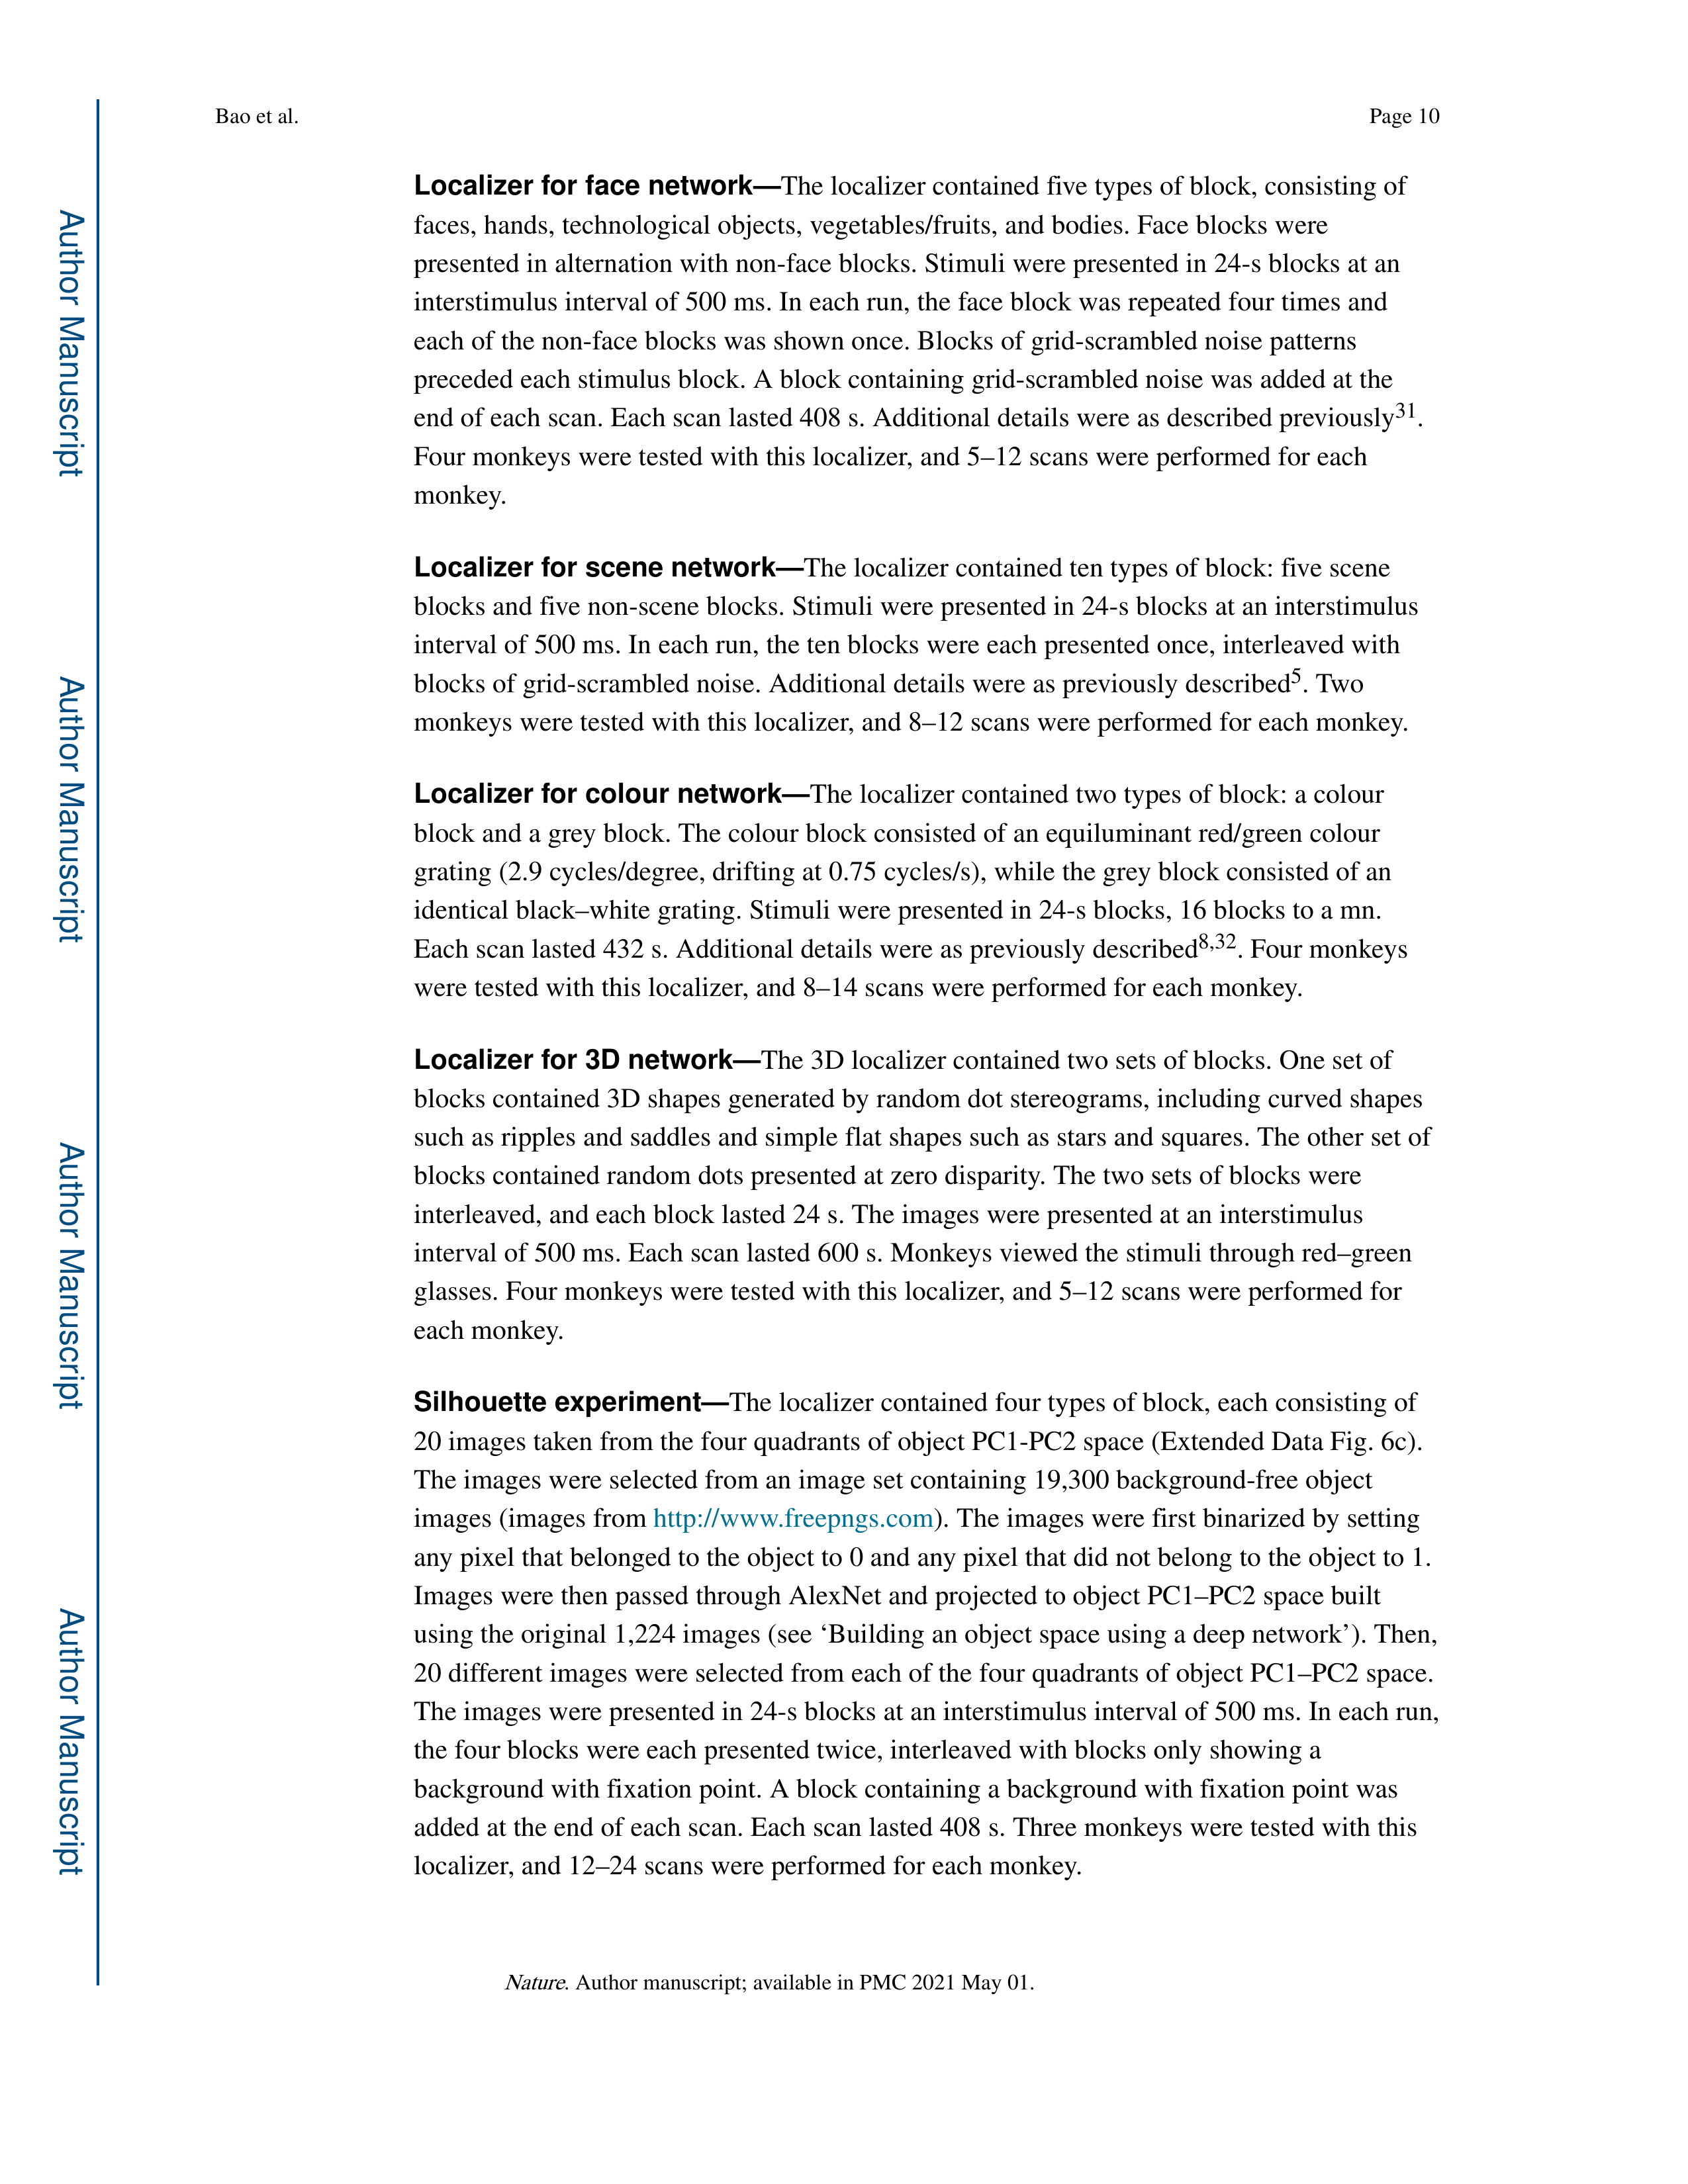

🕒 Total time taken: 19.8 seconds


In [5]:
# === Convert PDFs to images and generate a report ===

from pathlib import Path
from datetime import datetime, timezone
from tqdm import tqdm
import json
import time


# start time 
start_time = time.time()
# Load list of pdf paths
if 'pdf_paths' in globals():
    pdf_list = [Path(p) for p in pdf_paths]
else:
    raise RuntimeError("No PDFs found. Run the discovery cell first.")

# Ensure output dirs
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def progress(msg: str):
    print(msg)

# Convert
converter.reset_stats()
per_file_results = []
start_ts = datetime.now(timezone.utc).isoformat()

for pdf in tqdm(pdf_list, desc="Converting PDFs"):
    try:
        out_base = OUTPUT_DIR / pdf.stem
        # here you can change the method to either "pdf2image" or "fitz" or "both"
        # fitz is same as PyMuPDF
        method = "fitz"
        res = converter.convert_pdf(str(pdf), out_base, method=method, progress_callback=progress)
        per_file_results.append({
            "pdf": str(pdf),
            "output_base": str(out_base),
            "pdf2image_pages": len(res.get("pdf2image", [])),
            "fitz_pages": len(res.get("fitz", [])),
        })
    except Exception as e:
        per_file_results.append({
            "pdf": str(pdf),
            "output_base": str(OUTPUT_DIR / pdf.stem),
            "error": str(e),
        })

stats = converter.get_stats()
end_ts = datetime.now(timezone.utc).isoformat()

report = {
    "pipeline_step": "step1_pdf_to_images",
    "timestamp_start_utc": start_ts,
    "timestamp_end_utc": end_ts,
    "config": CONFIG,
    "input_pdfs": len(pdf_list),
    "summary": {
        "successful_files": stats["successful"],
        "failed_files": stats["failed"],
        "total_pages_converted": stats["total_pages"],
        "errors": stats["errors"],
    },
    "files": per_file_results,
    "output_root": str(OUTPUT_DIR),
}

# Save report
report_path = WORKSPACE_ROOT / "output_results" / "step1_pdf_conversion_report.json"
report_path.parent.mkdir(parents=True, exist_ok=True)
with open(report_path, "w") as f:
    json.dump(report, f, indent=2)

print("\n✅ Conversion complete")
print(f"   PDFs processed: {len(pdf_list)}")
print(f"   Successful files: {stats['successful']}")
print(f"   Failed files: {stats['failed']}")
print(f"   Total pages converted: {stats['total_pages']}")
print(f"   Report: {report_path}")

# Optional: show a few example outputs
examples_shown = 0
for entry in per_file_results:
    if examples_shown >= 3:
        break
    out_base = Path(entry.get("output_base", ""))
    fitz_dir = out_base / "fitz"
    # pdf2image_dir = out_base / "pdf2image"
    samples = []
    if fitz_dir.exists():
        samples += sorted(fitz_dir.glob("*.png"))[:1]
    # if pdf2image_dir.exists():
    #     samples += sorted(pdf2image_dir.glob("*.png"))[:1]
    if samples:
        print("Example outputs for:", out_base.name)
        for s in samples:
            display(Image.open(s))
        examples_shown += 1

# end time
end_time = time.time()
print(f"🕒 Total time taken: {round(end_time - start_time, 2)} seconds")

The results can be found in `output_results` folder. The file structure looks like this: 

```markdown
📁 output_results/
├── 📄 step1_pdf_conversion_report.json
└── 📁 converted_images/
    ├── 📁 PDF_1/
    │   └── 📁 fitz/
    │       └── 🖼️ PDF_1_page_1_fitz.png
            ├── ...
            └── 🖼️ PDF_1_page_xx_fitz.png
    └── 📁 PDF_2/
        └── ...
```